# Mutational and phenotypic accessibility of amino acid mutations

This notebook uses a 5-mer context model and elementary Markov chain theory to estimate the expected waiting time for each amino-acid mutation to occur in the chIgy BCR. Because some amino acid mutations require multiple codon nucleotide mutations, we can't compare mutation rates directly, but it does make sense to compare waiting times for amino acid mutations that require different numbers of mutations.

We then look at three features as predictors for AA mutation accessibility in replay histories:
- first-passage time
- codon edit distance
- maximum over mutational paths of the minimum phenotype along the path, for both binding and expression phenotypes


In [1]:
import numpy as np
import scipy
import pandas as pd
import itertools
import collections
from Bio.codonalign.codonseq import CodonSeq

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

import glob
import pickle

/opt/miniconda3/envs/replay/lib/python3.9/site-packages/Bio/codonalign/__init__.py:23: BiopythonExperimentalWarning: Bio.codonalign is an experimental module which may undergo significant changes prior to its future official release.
  warnings.warn(


## 5-mer context model parameters

In [2]:
mutability = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_mutability.csv", sep=" ", index_col=0).squeeze("columns")
substitution = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_substitution.csv", sep=" ", index_col=0)

In [3]:
mutability

Fivemer
AAAAA    0.000596
AAAAC    0.000865
AAAAG    0.000418
AAAAT    0.000588
AAAAN    0.000617
           ...   
NNTNA    0.000272
NNTNC    0.000398
NNTNG    0.000365
NNTNT    0.000383
NNTNN    0.000354
Name: Mutability, Length: 2500, dtype: float64

In [4]:
substitution

,A,C,G,T
Fivemer,,,,
AAAAA,0.000000,0.168399,0.727651,0.103950
AAAAC,0.000000,0.191268,0.704782,0.103950
AAAAG,0.000000,0.166320,0.723493,0.110187
AAAAT,0.000000,0.090909,0.863636,0.045455
AAAAN,0.000000,0.154224,0.754890,0.090885
...,...,...,...,...
NNTNA,0.276383,0.526126,0.197491,0.000000
NNTNC,0.263436,0.547941,0.188623,0.000000
NNTNG,0.265640,0.540766,0.193594,0.000000


## Contextualized codon states

We augment the 64-codon state space with the $5$-mer context of each codon position, giving 7-mers where the central triplet represents the codon.

In [5]:
k = 7
states = pd.Index(["".join(kmer) for kmer in itertools.product("ACGT", repeat=k)], name=f"{k}-mers")
states

Index(['AAAAAAA', 'AAAAAAC', 'AAAAAAG', 'AAAAAAT', 'AAAAACA', 'AAAAACC',
       'AAAAACG', 'AAAAACT', 'AAAAAGA', 'AAAAAGC',
       ...
       'TTTTTCG', 'TTTTTCT', 'TTTTTGA', 'TTTTTGC', 'TTTTTGG', 'TTTTTGT',
       'TTTTTTA', 'TTTTTTC', 'TTTTTTG', 'TTTTTTT'],
      dtype='object', name='7-mers', length=16384)

## Rate matrix $Q$

We will ignore mutations outside the central codon, and compute the sparse rate matrix using the mutability and substitution bias parameters on the three central codon positions.

In [6]:
# build row, column, and data arrays for the non-sparse component
row_idxs = []
col_idxs = []
data = []
for i, start_state in enumerate(states):
    for pos in range(k // 2 - 1, k // 2 + 2):
        start_state_list = list(start_state)
        for alt_base in "ACGT":
            if alt_base != start_state_list[pos]:
                end_state = start_state_list.copy()
                end_state[pos] = alt_base
                end_state = "".join(end_state)
                j = states.get_loc(end_state)
                row_idxs.append(i)
                col_idxs.append(j)
                data.append(mutability[start_state[pos - 2: pos + 3]] * substitution.loc[start_state[pos - 2: pos + 3], alt_base])

Q = scipy.sparse.coo_array((data, (row_idxs, col_idxs)), shape=(len(states), len(states)))

# fill in the diagonal
Q -= scipy.sparse.diags(Q.sum(axis=1))

Q


<16384x16384 sparse array of type '<class 'numpy.float64'>'
	with 163840 stored elements in Compressed Sparse Row format>

## Expected first-passage times

We want a matrix of expected first-passage times from each 7-mer state (rows) to each amino acid state set (columns) for the central codon. We solve a linear system for each column using a first-step approach. Let $\tau_i$ denote the expected first-passage time from 7-mer state index $i$ to any 7-mer state in the set $\mathcal{S}$ (i.e. with a common amino acid translation for the central codon). A standard result from Markov chain theory uses a first-step condition to derive the following linear system for the $\tau_i$.
$$
\begin{align*}
&\tau_i = 0, \quad &i \in \mathcal{S}\\
&1 + \sum_{j}Q_{ij}\tau_j = 0, \quad &i \notin \mathcal{S}
\end{align*}
$$

We can write the nontrivial part as
$$
Q'\boldsymbol{\tau} = -\boldsymbol{1},
$$
where $Q'$ is the sub-matrix of $Q$ obtained by excluding rows and columns corresponding to $\mathcal{S}$.

First we initialize the matrix of expected first-passage times to `NaN`, then fill in the trivial zero elements:

In [7]:
amino_acids = "ACDEFGHIKLMNPQRSTVWY*"

first_passage_times = pd.DataFrame(np.nan,
                                   index=states,
                                   columns=pd.Index(list(amino_acids), name="amino_acids"))
for state in states:
    amino_acid = CodonSeq(state[k // 2 - 1: k // 2 + 2]).translate()
    first_passage_times.loc[state, amino_acid] = 0.0

first_passage_times

amino_acids,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,*
7-mers,,,,,,,,,,,,,,,,,,,,,
AAAAAAA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAAAAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAAAAG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAAAAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAAACA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTGT,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTTTTTA,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTTTTTC,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now fill in the non-trivial elements by solving the sparse linear system for each column.

In [8]:
for amino_acid in first_passage_times.columns:
    nontrivial_idxs = first_passage_times[amino_acid] != 0.0
    first_passage_times[amino_acid].iloc[nontrivial_idxs] = scipy.sparse.linalg.spsolve(Q[nontrivial_idxs, :][:, nontrivial_idxs],
                                                                                        -np.ones(nontrivial_idxs.sum()))
# make sure we didn't miss any
assert first_passage_times.isna().sum().sum() == 0

first_passage_times

amino_acids,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,*
7-mers,,,,,,,,,,,,,,,,,,,,,
AAAAAAA,39487.801298,37714.530676,18205.607191,13175.618225,15946.700604,27921.666994,44041.615387,8516.850250,0.000000,10526.209071,...,13135.560751,72350.748825,36826.728431,10356.678112,10470.917885,13687.110997,12648.641447,77239.383752,20419.084828,16034.507225
AAAAAAC,39030.742209,58894.128991,24288.597342,14107.470722,19224.259324,29441.773434,60523.256142,12396.204777,0.000000,10550.967904,...,17091.969063,83345.645262,38391.552467,10138.930783,12097.196465,15121.469900,12770.224341,60769.090098,32163.594689,17960.297640
AAAAAAG,39725.265639,52275.851315,23709.253234,13158.391237,15768.695266,29236.105131,57086.060512,9890.588695,0.000000,10320.442931,...,18361.669614,78721.207389,32727.915331,10141.965131,11516.781371,14637.316601,12812.459105,60741.830073,29970.175192,15948.160640
AAAAAAT,34861.390128,37661.796838,18712.712207,12375.740077,14938.584801,26355.671311,46432.536031,9520.095012,0.000000,10947.448183,...,13855.952960,75621.290042,33298.037799,9783.182857,11861.318672,15256.520015,12618.276192,87044.033192,20119.650438,15071.928345
AAAAACA,43147.438985,23090.163212,21864.210780,39277.699357,14898.138941,12590.030475,55295.135669,11896.359563,0.000000,15602.524421,...,14841.168754,89114.642095,102245.661440,10096.776137,8364.410406,19564.089275,18625.589970,94411.377433,24649.728430,23572.204083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTGT,58806.629289,29374.182207,68866.180928,110949.964549,0.000000,70514.044568,29928.011136,13552.397859,89418.156464,4059.340362,...,51236.861536,17699.977074,61939.574581,27537.814789,8298.487019,36874.095572,19078.231312,111907.141194,19825.861274,38965.950066
TTTTTTA,36454.969143,26906.293012,54186.680111,81961.019685,0.000000,72393.029162,31264.453379,12865.405772,53601.127009,4524.107283,...,39372.487119,20208.280911,44541.795199,33804.371603,5700.876759,27134.950250,17849.852334,138028.473060,17096.021821,29840.562454
TTTTTTC,47963.632805,28587.199556,56329.080703,73573.331789,0.000000,80280.726136,37945.748201,15352.302401,61803.145828,4186.592004,...,46429.189134,23938.935769,61135.495546,38780.675742,6336.293458,34936.188775,17876.344815,68899.715200,18104.962774,33477.779322


## Apply to codons in our chIgy BCR

For every codon in our BCR, we take its 7-mer context and look up the corresponding row of first-passage times in the table above. For boundary codons we will pad with `NN` and take the geometric mean time over the 16 resolutions.

Load replay tree objects, so we can grab the root naive sequence.

In [9]:
results = "../nextflow/results/latest"

def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), int(PR_str[3])

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)

trees = {}
for file in files:
    key = "_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file)))
    # print(key)
    # if key.startswith("mouse7") or key.startswith("mouse8"):
    #     print(f"skipping 10-week {key}")
    #     continue
    assert key not in trees, key
    trees[key] = pickle.load(open(file, "rb"))

print(f"loaded {len(trees)} GC trees")



loaded 95 GC trees


Get the concatenated heavy/light chain naive sequence, and split into heavy and light chains.

In [10]:
naive = next(iter(trees.values())).tree.sequence

# the index of the first light chain base in the concatenated sequence
igk_idx = 336

naive_igh = CodonSeq(naive[:igk_idx])
naive_igk = CodonSeq(naive[igk_idx:])

We'll need this position dataframe to get IMGT-based numbering for sites

In [11]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
1,E,H,1,GAG,FWRH1
2,V,H,2,GTG,FWRH1
3,Q,H,3,CAG,FWRH1
4,L,H,4,CTT,FWRH1
5,Q,H,5,CAG,FWRH1
...,...,...,...,...,...
231,L,L,124,CTA,FWRL4
232,E,L,125,GAA,FWRL4
233,I,L,126,ATA,FWRL4


In [12]:
igh_pos_map = pos_df.loc[pos_df.chain == "H", ["site", "annotation"]].reset_index(drop=True)
igk_pos_map = pos_df.loc[pos_df.chain == "L", ["site", "annotation"]].reset_index(drop=True)

Build $\tau$ frame

In [13]:
chigy_first_passage_times = pd.DataFrame(index=pd.Index([f"H-{str(igh_pos_map.site[site]).zfill(3)}" for site in range(naive_igh.get_codon_num())]
                                                         + [f"L-{str(igk_pos_map.site[site]).zfill(3)}" for site in range(naive_igk.get_codon_num())],
                                                        name="site"))

chigy_mutability = pd.DataFrame(index=chigy_first_passage_times.index, columns=["mutability", "region", "codon", "amino acid"])

for chain, chain_seq, chain_pos_map in (("H", naive_igh, igh_pos_map), ("L", naive_igk, igk_pos_map)):
    for codon_idx in range(chain_seq.get_codon_num()):
        codon = chain_seq.get_codon(codon_idx)
        if codon_idx == 0:
            left_context = "NN"
        else:
            left_context = chain_seq.get_codon(codon_idx - 1)[1:]
        if codon_idx == chain_seq.get_codon_num() - 1:
            right_context = "NN"
        else:
            right_context = chain_seq.get_codon(codon_idx + 1)[:2]
        context = left_context + codon + right_context
        matching_7mer_idxs = first_passage_times.index.str.match(context.replace("N", "."))
        idx = f"{chain}-{str(chain_pos_map.site[codon_idx]).zfill(3)}"
        chigy_first_passage_times.loc[idx, first_passage_times.columns] = np.exp(np.log(first_passage_times.loc[matching_7mer_idxs, :]).mean(0))

        # codon mutatability, sum over codon positions, mean over matching 7mers
        chigy_mutability.mutability[idx] = np.array([np.array([mutability[match[pos - 2: pos + 3]] for pos in range(2, 5)]) for match in states[matching_7mer_idxs]]).sum(1).mean()
        chigy_mutability.region[idx] = chain_pos_map.annotation[codon_idx][:-1]
        chigy_mutability["codon"][idx] = codon
        chigy_mutability["amino acid"][idx] = CodonSeq(codon).translate()

display(chigy_first_passage_times)
display(chigy_mutability)

/opt/miniconda3/envs/replay/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,*
site,,,,,,,,,,,,,,,,,,,,,
H-001,41466.526708,39541.730543,42251.714512,0.000000,15518.633114,32414.098087,49340.994266,15141.284589,24774.026660,13483.179958,...,29973.392591,31203.819382,72550.511248,17803.374902,12411.418788,23141.159234,20922.936858,117681.015234,30449.261326,33842.205876
H-002,27974.791094,29885.408565,44666.304527,105679.203426,13915.155830,38152.656646,112542.967798,4872.902698,28773.080087,16441.623835,...,16245.672056,33189.300338,212393.010875,24161.189544,7019.438794,10732.766996,0.000000,194490.048738,26987.749589,51988.738764
H-003,36791.092845,17416.416816,53232.705001,157684.415444,9579.434486,57605.133054,64701.441421,15497.691168,54099.412570,14972.064368,...,23253.148805,29376.682298,0.000000,33317.641254,5819.385418,18220.379183,22190.978377,138425.237406,14215.880128,23355.173575
H-004,28748.309560,23772.714115,44907.561022,114200.854273,4928.447686,40358.179285,109165.967773,10383.564197,35879.199889,0.000000,...,17581.766369,28450.839900,217413.141097,28267.299324,4310.203769,13428.058176,12083.566792,195265.067371,20383.480162,54203.852159
H-005,58248.695500,34214.192355,67408.940229,89206.379936,11894.087585,63780.686673,25673.790474,19725.329160,65963.310783,7813.922698,...,50871.542086,20516.400959,0.000000,17650.201146,11319.591490,38849.755815,25068.306051,88422.618237,22769.907479,16612.442424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L-123,83868.356459,19378.530041,31729.138261,94980.123722,9866.482624,40462.755917,40009.353376,15199.628275,0.000000,11371.879426,...,20058.053716,45065.047995,88719.067713,22787.253154,9605.421955,48293.309088,22976.674971,130880.324276,17140.191767,36466.794169
L-124,26170.591796,74433.534762,44396.537423,65436.126487,13447.680349,44395.046081,136590.906079,11109.412150,29828.130752,0.000000,...,24761.944677,35802.700385,161330.076027,31727.769920,9692.983999,15146.678287,11459.429808,130260.734472,55695.344184,47372.694103
L-125,42771.086565,24560.581725,24704.262912,0.000000,11700.648363,36033.361762,40062.539374,11742.404064,5544.981132,9539.695749,...,17061.111389,69036.555108,28664.984603,15984.072776,10129.439745,20389.071411,15200.930415,61610.904388,14406.481579,10152.480532


,mutability,region,codon,amino acid
site,,,,
H-001,0.001639,FWRH,GAG,E
H-002,0.004501,FWRH,GTG,V
H-003,0.007436,FWRH,CAG,Q
H-004,0.005925,FWRH,CTT,L
H-005,0.00154,FWRH,CAG,Q
...,...,...,...,...
L-123,0.009467,FWRL,AAG,K
L-124,0.007261,FWRL,CTA,L
L-125,0.003231,FWRL,GAA,E


The geometric mean time

In [14]:
time_mean = scipy.stats.mstats.gmean(chigy_first_passage_times.replace(0, np.nan).values.flatten(),
                                     nan_policy="omit")
time_mean

31865.65067745182

Distribution of expected first-passage times over single-AA substitutions

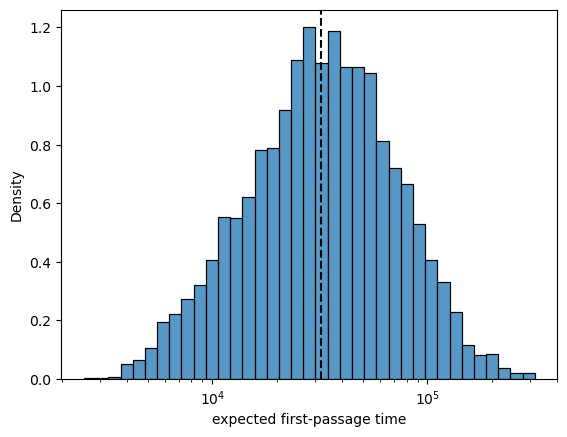

In [15]:
sns.histplot(chigy_first_passage_times.replace(0, np.nan).melt().value, stat="density", log_scale=True)
plt.axvline(time_mean, color="k", linestyle="--")
plt.xlabel("expected first-passage time")
plt.show()

Heatmap of expected first-passage times (sites $\times$ AAs)

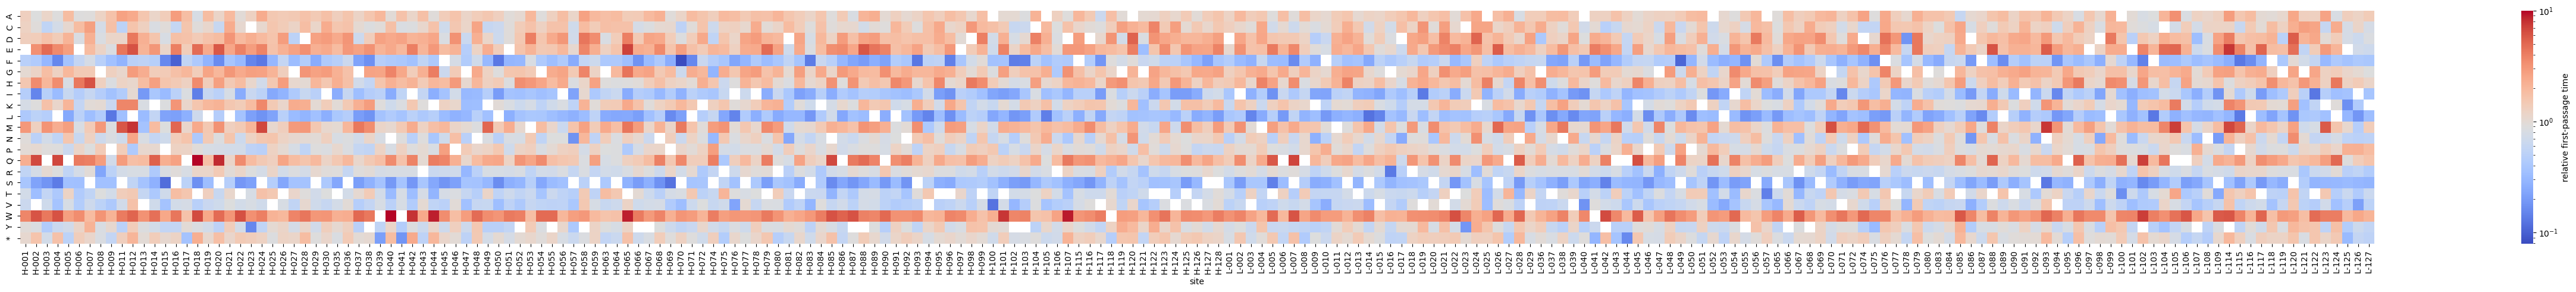

In [16]:
plt.figure(figsize=(50, 5))
sns.heatmap(chigy_first_passage_times.T / time_mean, cmap="coolwarm",
            norm=LogNorm(vmax=10),
            cbar_kws=dict(label="relative first-passage time"))
plt.tight_layout()
plt.show()

Mutability by site and region

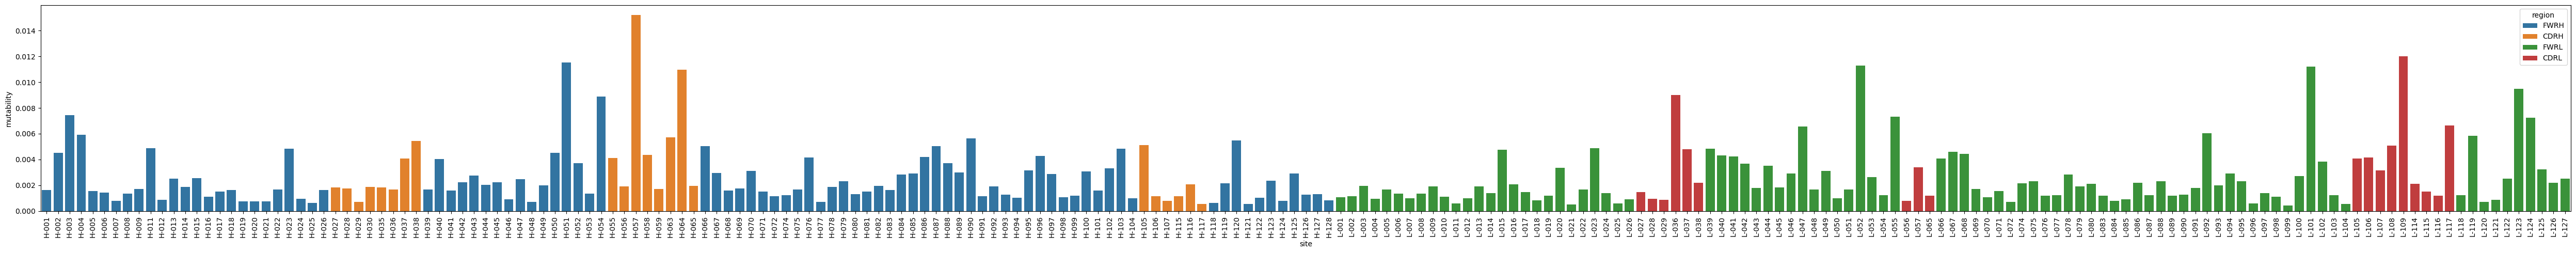

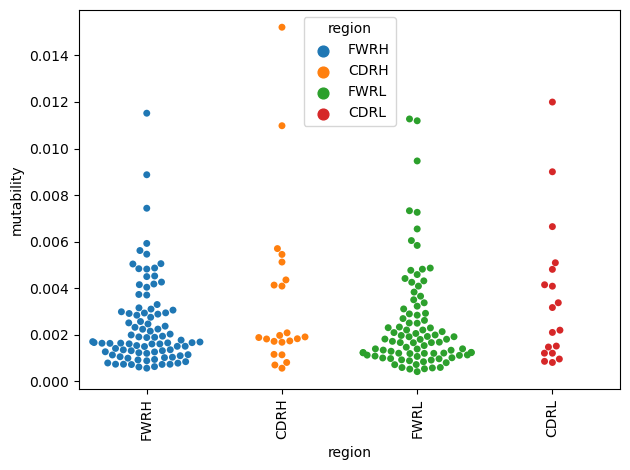

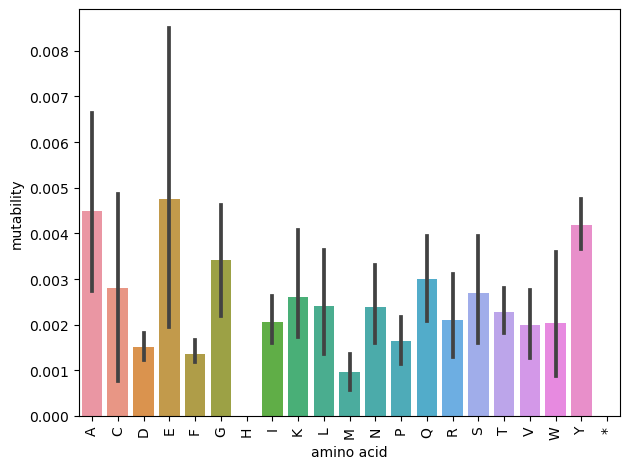

In [17]:
plt.figure(figsize=(50, 5))
sns.barplot(data=chigy_mutability.reset_index(), x="site", y="mutability", hue="region", dodge=False)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

sns.swarmplot(data=chigy_mutability, x="region", y="mutability", hue="region", dodge=False)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

sns.barplot(data=chigy_mutability, x="amino acid", y="mutability", dodge=False, order=amino_acids)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Waiting times Vs minimum edit distance

Compile a table of minimal codon edit distances. First will need a backtranslation dictionary:

In [18]:
backtranslations = collections.defaultdict(list)
for codon in itertools.product("ACGT", repeat=3):
    codon = "".join(codon)
    backtranslations[CodonSeq(codon).translate()].append(codon)

backtranslations

defaultdict(list,
            {'K': ['AAA', 'AAG'],
             'N': ['AAC', 'AAT'],
             'T': ['ACA', 'ACC', 'ACG', 'ACT'],
             'R': ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT'],
             'S': ['AGC', 'AGT', 'TCA', 'TCC', 'TCG', 'TCT'],
             'I': ['ATA', 'ATC', 'ATT'],
             'M': ['ATG'],
             'Q': ['CAA', 'CAG'],
             'H': ['CAC', 'CAT'],
             'P': ['CCA', 'CCC', 'CCG', 'CCT'],
             'L': ['CTA', 'CTC', 'CTG', 'CTT', 'TTA', 'TTG'],
             'E': ['GAA', 'GAG'],
             'D': ['GAC', 'GAT'],
             'A': ['GCA', 'GCC', 'GCG', 'GCT'],
             'G': ['GGA', 'GGC', 'GGG', 'GGT'],
             'V': ['GTA', 'GTC', 'GTG', 'GTT'],
             '*': ['TAA', 'TAG', 'TGA'],
             'Y': ['TAC', 'TAT'],
             'C': ['TGC', 'TGT'],
             'W': ['TGG'],
             'F': ['TTC', 'TTT']})

In [19]:
chigy_edit_dists = pd.DataFrame(index=pd.Index([f"H-{str(igh_pos_map.site[site]).zfill(3)}" for site in range(naive_igh.get_codon_num())]
                                                + [f"L-{str(igk_pos_map.site[site]).zfill(3)}" for site in range(naive_igk.get_codon_num())],
                                               name="site"))

for chain, chain_seq, chain_pos_map in (("H", naive_igh, igh_pos_map), ("L", naive_igk, igk_pos_map)):
    for codon_idx in range(chain_seq.get_codon_num()):
        codon = chain_seq.get_codon(codon_idx)
        for aa in amino_acids:
            chigy_edit_dists.loc[f"{chain}-{str(chain_pos_map.site[codon_idx]).zfill(3)}", aa] = min(sum(x != y for x, y in zip(codon, alt_codon)) for alt_codon in backtranslations[aa])

chigy_edit_dists = chigy_edit_dists.astype(int)
# chigy_edit_dists[chigy_edit_dists == 0] = pd.NA

chigy_edit_dists

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,*
site,,,,,,,,,,,,,,,,,,,,,
H-001,1,3,1,0,3,1,2,3,1,2,...,2,2,1,2,2,2,1,2,2,1
H-002,1,3,2,1,2,1,3,2,2,1,...,3,2,2,2,2,2,0,2,3,2
H-003,2,3,2,1,3,2,1,3,1,1,...,2,1,0,1,2,2,2,2,2,1
H-004,2,2,2,3,1,2,1,1,3,0,...,2,1,2,1,2,2,1,3,2,3
H-005,2,3,2,1,3,2,1,3,1,1,...,2,1,0,1,2,2,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L-123,2,3,2,1,3,2,2,2,0,2,...,1,2,1,1,2,1,2,2,2,1
L-124,2,3,3,2,2,2,2,1,2,0,...,3,1,1,1,2,2,1,3,3,2
L-125,1,3,1,0,3,1,2,2,1,2,...,2,2,1,2,2,2,1,3,2,1


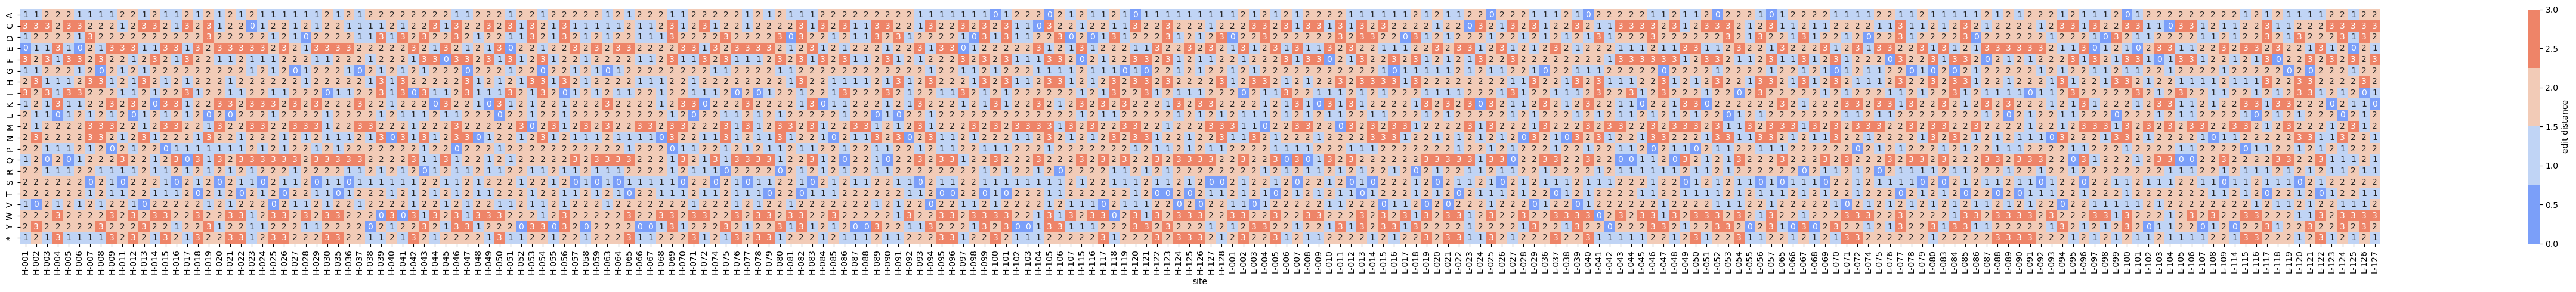

In [20]:
plt.figure(figsize=(50, 5))
sns.heatmap(chigy_edit_dists.T, cmap=sns.color_palette("coolwarm", n_colors=4),
            annot=chigy_edit_dists.T,
            cbar_kws=dict(label="edit distance"))
plt.tight_layout()
plt.show()

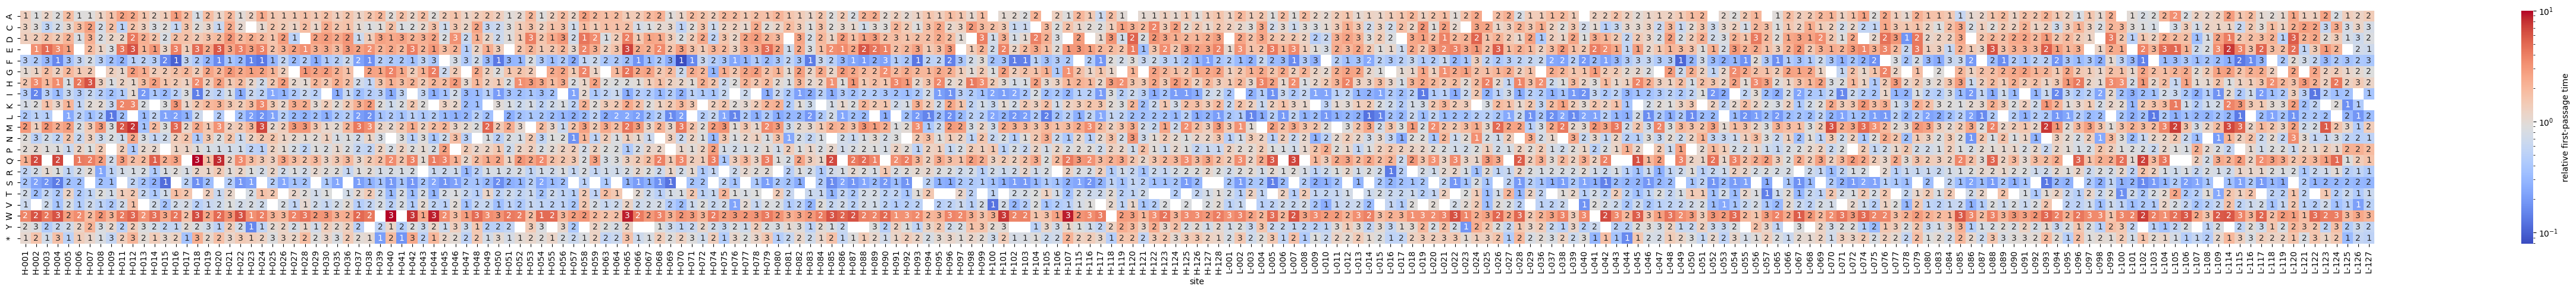

In [21]:
plt.figure(figsize=(50, 5))
sns.heatmap(chigy_first_passage_times.T / time_mean, cmap="coolwarm",
            annot=chigy_edit_dists.T,
            norm=LogNorm(vmax=10),
            cbar_kws=dict(label="relative first-passage time"))
plt.tight_layout()
plt.show()

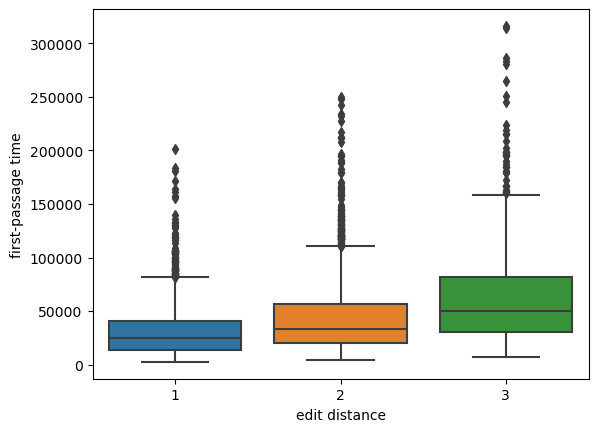

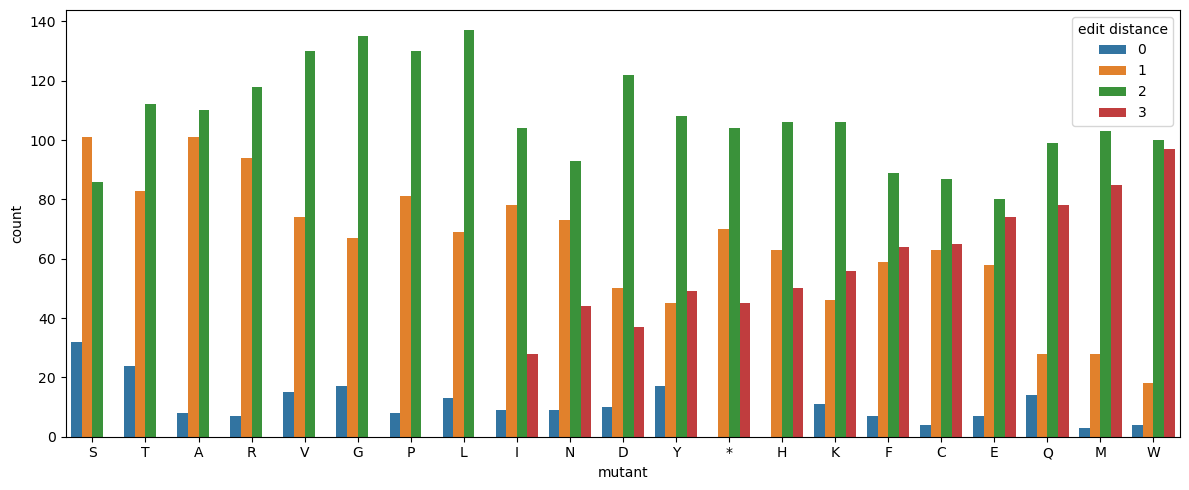

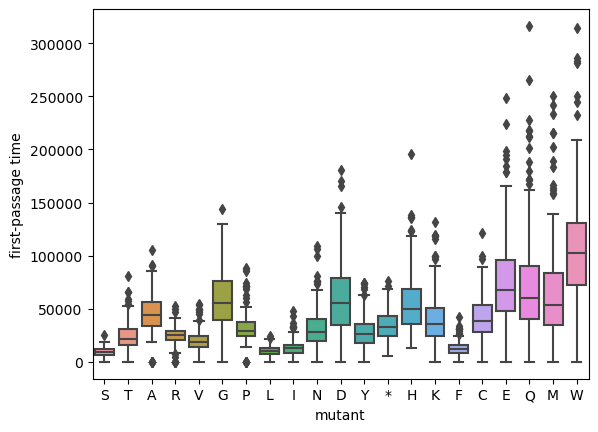

In [22]:
time_dist_df = chigy_first_passage_times.melt(var_name="mutant", value_name="first-passage time", ignore_index=False).reset_index().merge(chigy_edit_dists.melt(var_name="mutant", value_name="edit distance", ignore_index=False).reset_index(), on=['mutant', 'site'])

aa_sorted_by_mean_edit_dist = time_dist_df.groupby("mutant")["edit distance"].mean().sort_values().index

sns.boxplot(data=time_dist_df, x="edit distance", y="first-passage time", order=[1, 2, 3])
plt.show()

plt.figure(figsize=(12, 5))
sns.countplot(data=time_dist_df, x="mutant", hue="edit distance", order=aa_sorted_by_mean_edit_dist)#, multiple="stack", discrete=True)
plt.tight_layout()
plt.show()

# plt.figure(figsize=(10, 5))
# sns.histplot(data=time_dist_df, x="mutant", y="edit distance", discrete=True)
# plt.show()

sns.boxplot(data=time_dist_df, x="mutant", y="first-passage time", order=aa_sorted_by_mean_edit_dist)
plt.show()

## Phenotypic effects Vs mutational accessibility of amino acid substitutions

The results above paint a picture of the mutational accessibility of amino acid substitutions. Now we compare this picture to DMS data on molecular phenotypes.

In [23]:
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMGT.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]
dms_df

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,10.48829,...,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,False,H-001
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,10.44477,...,10.32364,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0,False,H-001
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,10.42771,...,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0,False,H-001
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,10.45719,...,10.45067,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0,True,H-001
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,10.51899,...,10.33163,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,10.44756,...,10.54313,0.09246,39.0,2.0,6.93925,0.07866,33.0,2.0,False,L-128
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,10.43023,...,10.53860,0.08793,36.0,2.0,6.88956,0.02896,34.0,2.0,False,L-128
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,10.38231,...,10.48707,0.03640,27.0,2.0,6.78160,-0.07899,24.0,2.0,False,L-128


Heatmap of affinity effects

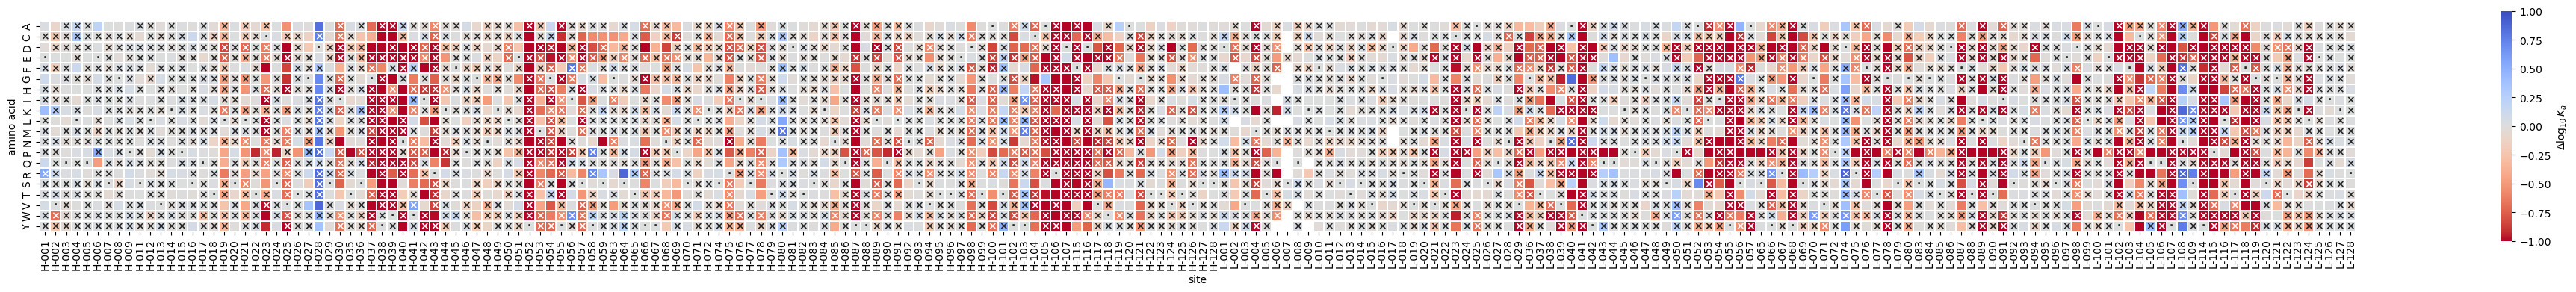

In [24]:
bind_df = dms_df.pivot(index="mutant", columns="site", values="delta_bind_CGG")

accessible_df = dms_df.pivot(index="mutant", columns="site", values="single_nt")
wt_df = dms_df.pivot(index="mutant", columns="site", values="WT")

annot = pd.DataFrame(np.empty_like(bind_df, dtype=str), index=bind_df.index, columns=bind_df.columns)
annot.iloc[wt_df.values.astype(bool)] = "\u00B7"
annot.iloc[~accessible_df.values.astype(bool)] = "\u00D7"

vmax = 1
vmin = -1

plt.figure(figsize=(50, 4))
sns.heatmap(bind_df, center=0, vmin=vmin, vmax=vmax, annot=annot, fmt="", annot_kws=dict(fontweight="bold"),
            cmap="coolwarm_r", cbar_kws=dict(label=r"$\Delta\log_{10} K_a$"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.show()

Add first-passage time estimates and edit distances to DMS dataframe

In [25]:
df = time_dist_df.set_index(["site", "mutant"]).join(dms_df.reset_index().set_index(["site", "mutant"])).reset_index().set_index("mutation")

assert df.loc[df.WT == False, "first-passage time"].min() > 0

df.query("WT == False", inplace=True)

df

,site,mutant,first-passage time,edit distance,target,wildtype,position,position_IMGT,chain,annotation,...,n_libs_bind_TuGG,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,H-001,A,41466.526708,1,CGG_naive,E,1.0,1,H,FWRH1,...,2.0,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,False
V2(H)A,H-002,A,27974.791094,1,CGG_naive,V,2.0,2,H,FWRH1,...,2.0,10.51195,0.06128,33.0,2.0,6.86903,0.00843,31.0,2.0,False
Q3(H)A,H-003,A,36791.092845,2,CGG_naive,Q,3.0,3,H,FWRH1,...,2.0,10.47354,0.02287,30.0,2.0,6.80635,-0.05424,28.0,2.0,False
L4(H)A,H-004,A,28748.309560,2,CGG_naive,L,4.0,4,H,FWRH1,...,2.0,10.45742,0.00675,58.0,2.0,8.28848,1.42788,51.0,2.0,False
Q5(H)A,H-005,A,58248.695500,2,CGG_naive,Q,5.0,5,H,FWRH1,...,2.0,10.36985,-0.08082,48.0,2.0,6.81531,-0.04529,42.0,2.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K123(L)Y,L-123,Y,17140.191767,2,CGG_naive,K,230.0,123,L,FWRL4,...,2.0,10.47131,0.02064,27.0,2.0,6.86898,0.00838,23.0,2.0,False
L124(L)Y,L-124,Y,55695.344184,3,CGG_naive,L,231.0,124,L,FWRL4,...,2.0,9.21565,-1.23502,30.0,2.0,7.66604,0.80544,29.0,2.0,False
E125(L)Y,L-125,Y,14406.481579,2,CGG_naive,E,232.0,125,L,FWRL4,...,2.0,10.32329,-0.12738,35.0,2.0,7.07218,0.21158,30.0,2.0,False


Scatterplot of affinity effects Vs first-passage time for each site $\times$ AA substitution

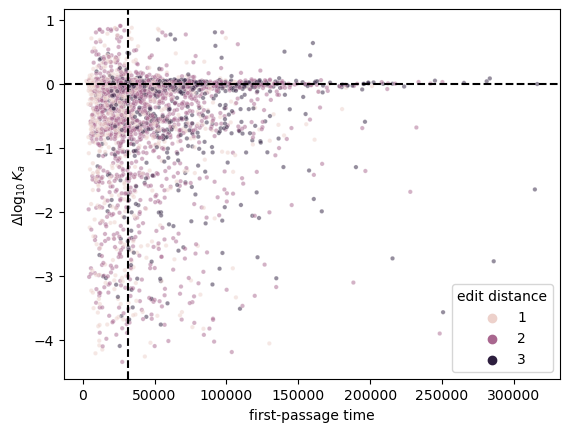

In [26]:
sns.scatterplot(data=df, x="first-passage time", y="delta_bind_CGG", hue="edit distance", s=10, alpha=0.5)
plt.axhline(0, color="k", linestyle="--")
plt.axvline(time_mean, color="k", linestyle="--")
# plt.xscale("log")
plt.ylabel(r"$\Delta\log_{10} K_a$")
plt.show()

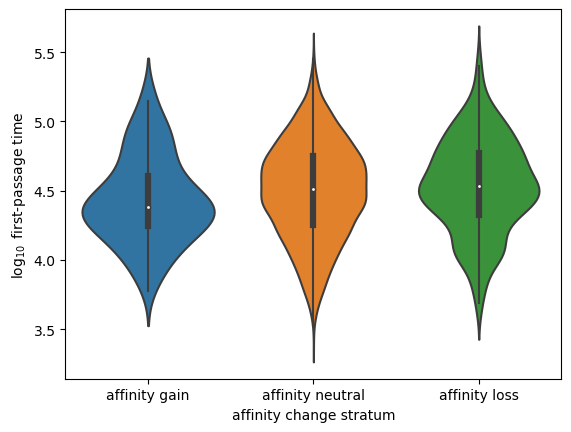

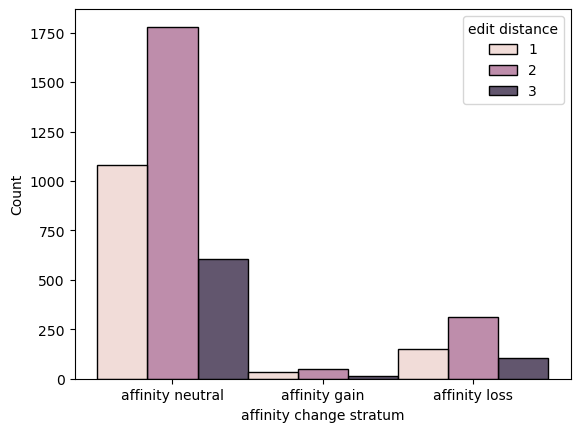

In [27]:
gain_thresh = 0.3
loss_thresh = -1
df.loc[~df.delta_bind_CGG.isna(), "affinity change stratum"] = "affinity neutral"
df.loc[df["delta_bind_CGG"] > gain_thresh, "affinity change stratum"] = "affinity gain"
df.loc[df["delta_bind_CGG"] < loss_thresh, "affinity change stratum"] = "affinity loss"

sns.violinplot(data=df, x="affinity change stratum", y=np.log10(df["first-passage time"]), order=["affinity gain", "affinity neutral", "affinity loss"])
plt.ylabel(r"$\log_{10}$ first-passage time")
plt.show()

sns.histplot(data=df, x="affinity change stratum", hue="edit distance", discrete=True, multiple="dodge")
plt.show()


Mann-Whitney test for affinity gain Vs loss

In [28]:
scipy.stats.mannwhitneyu(df.loc[(df["affinity change stratum"] == "affinity gain"), "first-passage time"],
                         df.loc[(df["affinity change stratum"] == "affinity loss"), "first-passage time"],
                         alternative="less")

MannwhitneyuResult(statistic=22759.0, pvalue=0.0007629269923218118)

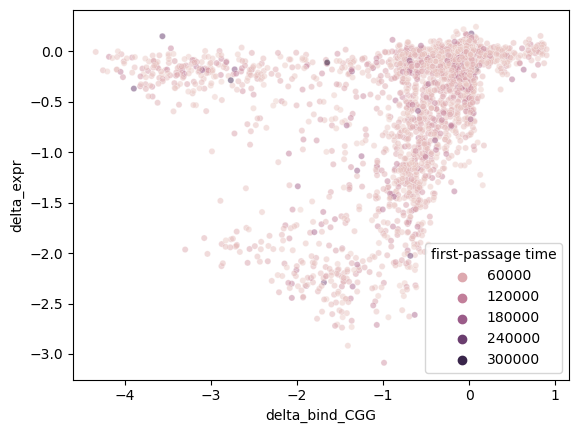

In [29]:
sns.scatterplot(data=df, x="delta_bind_CGG", y="delta_expr", hue="first-passage time", s=20, alpha=0.5)
plt.show()

## Mutation incidence in replayed histories

In [30]:
hits_df = pd.DataFrame(np.zeros_like(bind_df.values), index=bind_df.index, columns=bind_df.columns)

df["mutation events (20-day)"] = 0
df["mutation events (10-week)"] = 0
df["mutation events (LMP2A)"] = 0
df["mutation events"] = 0

for gc, tree in trees.items():
    mouse_num = int(gc.split("_")[0][5:])
    if mouse_num in range(1, 7):
        suffix = "20-day"
    elif mouse_num in (7, 8):
        suffix = "10-week"
    elif mouse_num in (11, 12):
        suffix = "LMP2A"
    else:
        raise ValueError(f"unknown mouse {mouse_num}")
    for node in tree.tree.iter_descendants(strategy="preorder"):
        for mutation in set(node.mutations) - set(node.up.mutations):
            mutant = mutation[-1]
            if mutant != "*":
                site = df.site[mutation]
                hits_df.loc[mutant, site] += 1
                df.loc[mutation, "mutation events"] += 1
                df.loc[mutation, f"mutation events ({suffix})"] += 1

hits_df

site,H-001,H-002,H-003,H-004,H-005,H-006,H-007,H-008,H-009,H-011,...,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128
mutant,,,,,,,,,,,,,,,,,,,,,
A,4.0,2.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,...,6.0,7.0,0.0,3.0,1.0,1.0,3.0,2.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,14.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,4.0,0.0,0.0,0.0,4.0,0.0,30.0,0.0,0.0,0.0
E,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,6.0,0.0,26.0,0.0,0.0,0.0,30.0,0.0
F,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
G,7.0,1.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,11.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
H,0.0,0.0,7.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,5.0,1.0,1.0,0.0,0.0,13.0,0.0
K,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,14.0,0.0,0.0


In [31]:
df

,site,mutant,first-passage time,edit distance,target,wildtype,position,position_IMGT,chain,annotation,...,psr,delta_psr,n_bc_psr,n_libs_psr,WT,affinity change stratum,mutation events (20-day),mutation events (10-week),mutation events (LMP2A),mutation events
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,H-001,A,41466.526708,1,CGG_naive,E,1.0,1,H,FWRH1,...,6.78608,-0.07452,17.0,2.0,False,affinity neutral,4,0,0,4
V2(H)A,H-002,A,27974.791094,1,CGG_naive,V,2.0,2,H,FWRH1,...,6.86903,0.00843,31.0,2.0,False,affinity neutral,1,1,0,2
Q3(H)A,H-003,A,36791.092845,2,CGG_naive,Q,3.0,3,H,FWRH1,...,6.80635,-0.05424,28.0,2.0,False,affinity neutral,0,0,0,0
L4(H)A,H-004,A,28748.309560,2,CGG_naive,L,4.0,4,H,FWRH1,...,8.28848,1.42788,51.0,2.0,False,affinity neutral,0,0,0,0
Q5(H)A,H-005,A,58248.695500,2,CGG_naive,Q,5.0,5,H,FWRH1,...,6.81531,-0.04529,42.0,2.0,False,affinity neutral,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K123(L)Y,L-123,Y,17140.191767,2,CGG_naive,K,230.0,123,L,FWRL4,...,6.86898,0.00838,23.0,2.0,False,affinity neutral,0,0,0,0
L124(L)Y,L-124,Y,55695.344184,3,CGG_naive,L,231.0,124,L,FWRL4,...,7.66604,0.80544,29.0,2.0,False,affinity neutral,0,0,0,0
E125(L)Y,L-125,Y,14406.481579,2,CGG_naive,E,232.0,125,L,FWRL4,...,7.07218,0.21158,30.0,2.0,False,affinity neutral,0,0,0,0


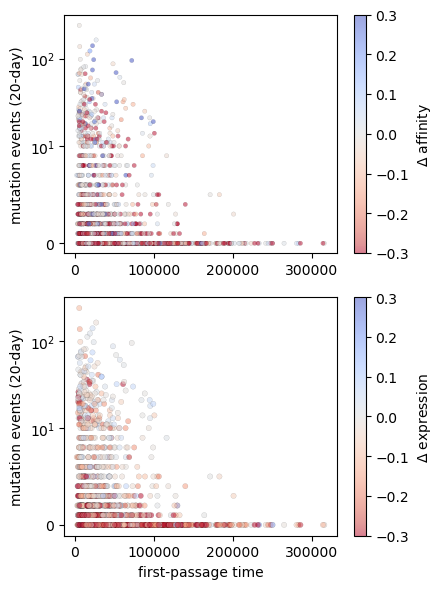

In [32]:
plt.figure(figsize=(4.5, 6))

ax = plt.subplot(211)
plt.scatter(df["first-passage time"], df["mutation events (20-day)"], c=df["delta_bind_CGG"], s=10, alpha=0.5,
            cmap="coolwarm_r", vmin=-0.3, vmax=0.3,
            clip_on=False, edgecolors="k", linewidths=0.1)
# plt.xlabel("mutation rate")
plt.ylabel("mutation events (20-day)")
linthresh_y = 10
# plt.xscale("log")
plt.yscale("symlog", linthresh=linthresh_y)
plt.ylim(-1, None)
plt.colorbar(label=r"$\Delta$ affinity")

plt.subplot(212, sharex=ax)
plt.scatter(df["first-passage time"], df["mutation events (20-day)"], c=df["delta_expr"], s=15, alpha=0.5,
            cmap="coolwarm_r", vmin=-0.3, vmax=0.3,
            clip_on=False, edgecolors="k", linewidths=0.1)
plt.xlabel("first-passage time")
plt.ylabel("mutation events (20-day)")
# plt.xscale("log")
plt.yscale("symlog", linthresh=linthresh_y)
# plt.ylim(0, None)
plt.colorbar(label=r"$\Delta$ expression")

plt.tight_layout()
plt.show()

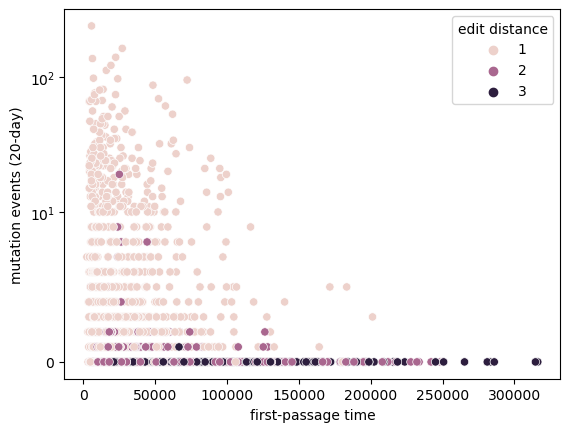

In [33]:
sns.scatterplot(data=df, hue="edit distance", x="first-passage time", y="mutation events (20-day)")
# plt.xscale("log")
plt.yscale("symlog", linthresh=linthresh_y)
plt.show()

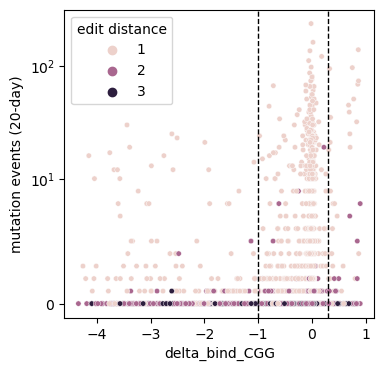

In [34]:
plt.figure(figsize=(4, 4))
sns.scatterplot(data=df, hue="edit distance", x="delta_bind_CGG", y="mutation events (20-day)", s=15)
plt.yscale("symlog", linthresh=linthresh_y)
plt.axvline(0.3, color="k", linestyle="--", lw=1)
plt.axvline(-1, color="k", linestyle="--", lw=1)
plt.show()

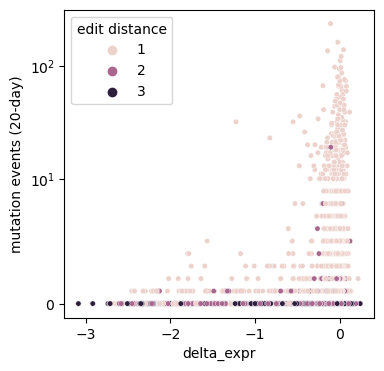

In [35]:
plt.figure(figsize=(4, 4))
sns.scatterplot(data=df, hue="edit distance", x="delta_expr", y="mutation events (20-day)", s=15)
plt.yscale("symlog", linthresh=linthresh_y)
plt.show()

## GP map / paths through low-affinity intermediates

We'd like to analyze the phenotypic intermediates that must be traversed to reach high-affinity AA substitutions. Do low-intermediate states predict low incidence in replayed histories?

For every AA substitution that requires at least two nt mutations, we'll take the set of all mutation orders to all synonymous alternative codons at the minimum edit distance, and take the worst phenotype encountered for any intermediate.

First we'll add codon info to our data frame:

In [36]:
df["WT codon"] = [chigy_mutability.codon[site] for site in df.site]

df["mutant codons"] = [[codon for codon in backtranslations[row.mutant]
                        if sum(x != y for x, y in zip(codon, row["WT codon"])) == row["edit distance"]]
                       for mutant, row in df.iterrows()]

df

,site,mutant,first-passage time,edit distance,target,wildtype,position,position_IMGT,chain,annotation,...,n_bc_psr,n_libs_psr,WT,affinity change stratum,mutation events (20-day),mutation events (10-week),mutation events (LMP2A),mutation events,WT codon,mutant codons
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,H-001,A,41466.526708,1,CGG_naive,E,1.0,1,H,FWRH1,...,17.0,2.0,False,affinity neutral,4,0,0,4,GAG,[GCG]
V2(H)A,H-002,A,27974.791094,1,CGG_naive,V,2.0,2,H,FWRH1,...,31.0,2.0,False,affinity neutral,1,1,0,2,GTG,[GCG]
Q3(H)A,H-003,A,36791.092845,2,CGG_naive,Q,3.0,3,H,FWRH1,...,28.0,2.0,False,affinity neutral,0,0,0,0,CAG,[GCG]
L4(H)A,H-004,A,28748.309560,2,CGG_naive,L,4.0,4,H,FWRH1,...,51.0,2.0,False,affinity neutral,0,0,0,0,CTT,[GCT]
Q5(H)A,H-005,A,58248.695500,2,CGG_naive,Q,5.0,5,H,FWRH1,...,42.0,2.0,False,affinity neutral,0,0,0,0,CAG,[GCG]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K123(L)Y,L-123,Y,17140.191767,2,CGG_naive,K,230.0,123,L,FWRL4,...,23.0,2.0,False,affinity neutral,0,0,0,0,AAG,"[TAC, TAT]"
L124(L)Y,L-124,Y,55695.344184,3,CGG_naive,L,231.0,124,L,FWRL4,...,29.0,2.0,False,affinity neutral,0,0,0,0,CTA,"[TAC, TAT]"
E125(L)Y,L-125,Y,14406.481579,2,CGG_naive,E,232.0,125,L,FWRL4,...,30.0,2.0,False,affinity neutral,0,0,0,0,GAA,"[TAC, TAT]"


Maximum over paths of the minimum phenotype intermediate along each path. We'll use -10 to mark phenotypes of stop codons.

In [68]:
for mutation, row in df.query("`edit distance` > 1").iterrows():
    maximin_bind = -np.inf
    maximin_expr = -np.inf
    for mutant_codon in row["mutant codons"]:
        mutant_positions = [pos for pos in range(3) if row["WT codon"][pos] != mutant_codon[pos]]
        assert len(mutant_positions) == row["edit distance"]
        mutant_codon = list(mutant_codon)
        wt_codon = list(row["WT codon"])
        # single-mutant intermediates for 2-mutant codons
        if len(mutant_positions) == 2:
            for pos in mutant_positions:
                intermediate_codon = wt_codon.copy()
                intermediate_codon[pos] = mutant_codon[pos]
                intermediate_aa = CodonSeq("".join(intermediate_codon)).translate()
                assert intermediate_aa != row.mutant
                if intermediate_aa == row.wildtype:
                    intermediate_bind = 0
                    intermediate_expr = 0
                elif intermediate_aa == "*":
                    intermediate_bind = -10
                    intermediate_expr = -10
                else:
                    intermediate_bind = df.delta_bind_CGG[mutation[:-1] + intermediate_aa]
                    intermediate_expr = df.delta_expr[mutation[:-1] + intermediate_aa]
                if intermediate_bind > maximin_bind:
                    maximin_bind = intermediate_bind
                if intermediate_expr > maximin_expr:
                    maximin_expr = intermediate_expr

        # single- and double-mutant intermediates for 3-mutant codons
        elif len(mutant_positions) == 3:
            for pos1, pos2 in itertools.permutations(mutant_positions, 2):
                path_min_bind = np.inf
                path_min_expr = np.inf
                intermediate_codon = wt_codon.copy()
                for pos in (pos1, pos2):
                    intermediate_codon[pos] = mutant_codon[pos]
                    intermediate_aa = CodonSeq("".join(intermediate_codon)).translate()
                    assert intermediate_aa != row.mutant
                    if intermediate_aa == row.wildtype:
                        path_point_bind = 0
                        path_point_expr = 0
                    elif intermediate_aa == "*":
                        path_point_bind = -10
                        path_point_expr = -10
                    else:
                        path_point_bind = df.delta_bind_CGG[mutation[:-1] + intermediate_aa]
                        path_point_expr = df.delta_expr[mutation[:-1] + intermediate_aa]
                    if path_point_bind < path_min_bind:
                        path_min_bind = path_point_bind
                    if path_point_expr < path_min_expr:
                        path_min_expr = path_point_expr

                if path_min_bind > maximin_bind:
                    maximin_bind = path_min_bind
                if path_min_expr > maximin_expr:
                    maximin_expr = path_min_expr

        else:
            raise ValueError(mutant_positions)

    df.loc[mutation, "maximin_intermediate_bind"] = maximin_bind
    df.loc[mutation, "maximin_intermediate_expr"] = maximin_expr

df.maximin_intermediate_bind.replace(-np.inf, np.nan, inplace=True)
df.maximin_intermediate_expr.replace(-np.inf, np.nan, inplace=True)

df

,site,mutant,first-passage time,edit distance,target,wildtype,position,position_IMGT,chain,annotation,...,WT,affinity change stratum,mutation events (20-day),mutation events (10-week),mutation events (LMP2A),mutation events,WT codon,mutant codons,maximin_intermediate_bind,maximin_intermediate_expr
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,H-001,A,41466.526708,1,CGG_naive,E,1.0,1,H,FWRH1,...,False,affinity neutral,4,0,0,4,GAG,[GCG],NaN,NaN
V2(H)A,H-002,A,27974.791094,1,CGG_naive,V,2.0,2,H,FWRH1,...,False,affinity neutral,1,1,0,2,GTG,[GCG],NaN,NaN
Q3(H)A,H-003,A,36791.092845,2,CGG_naive,Q,3.0,3,H,FWRH1,...,False,affinity neutral,0,0,0,0,CAG,[GCG],0.00304,-0.02674
L4(H)A,H-004,A,28748.309560,2,CGG_naive,L,4.0,4,H,FWRH1,...,False,affinity neutral,0,0,0,0,CTT,[GCT],0.02878,0.04515
Q5(H)A,H-005,A,58248.695500,2,CGG_naive,Q,5.0,5,H,FWRH1,...,False,affinity neutral,0,0,0,0,CAG,[GCG],0.04559,-0.00303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K123(L)Y,L-123,Y,17140.191767,2,CGG_naive,K,230.0,123,L,FWRL4,...,False,affinity neutral,0,0,0,0,AAG,"[TAC, TAT]",-0.11044,0.07952
L124(L)Y,L-124,Y,55695.344184,3,CGG_naive,L,231.0,124,L,FWRL4,...,False,affinity neutral,0,0,0,0,CTA,"[TAC, TAT]",-0.04725,-0.10630
E125(L)Y,L-125,Y,14406.481579,2,CGG_naive,E,232.0,125,L,FWRL4,...,False,affinity neutral,0,0,0,0,GAA,"[TAC, TAT]",0.01137,0.05632


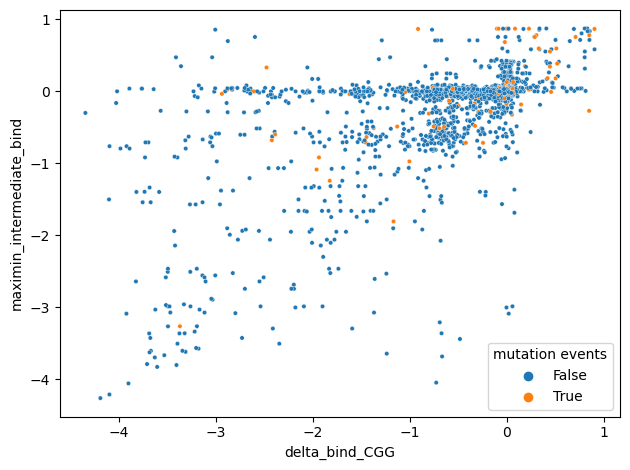

In [69]:
sns.scatterplot(data=df.query("`edit distance` > 1"), x="delta_bind_CGG", y="maximin_intermediate_bind", hue=df["mutation events"] > 0, s=10)
plt.tight_layout()
plt.show()

The above doesn't seem to support phenotype loss in interemediates as an explanationn for affinity improving mutation non-incidence in replay histories.

Possible explanations explored here are: edit distance, hotspot-based waiting time, and intermediate phenotype loss.

All plots in the cell below are for affinity-gain mutations.

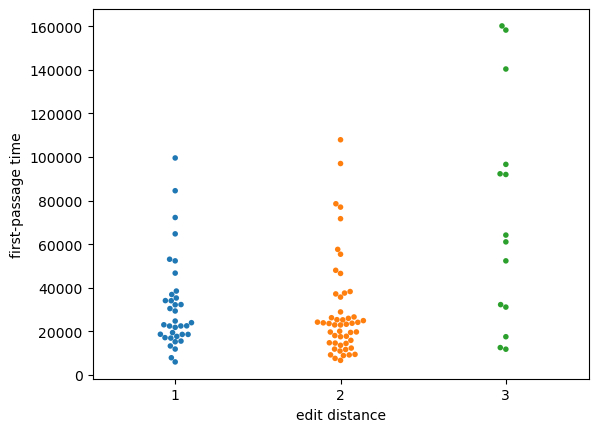

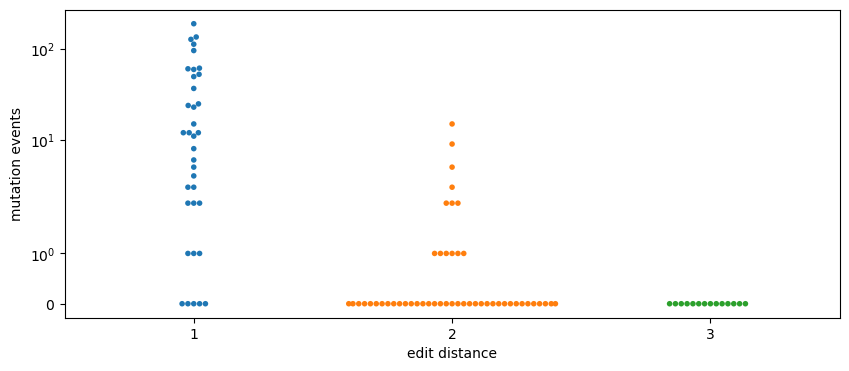

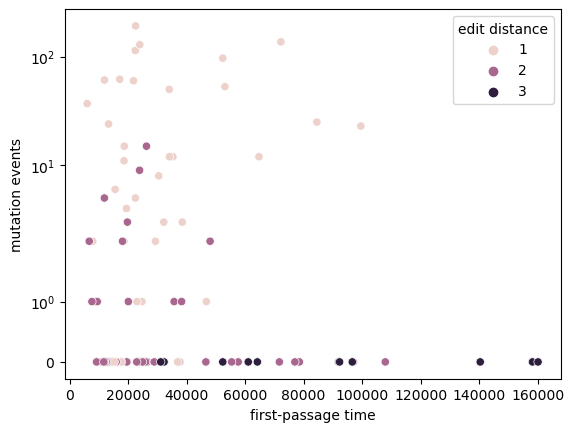

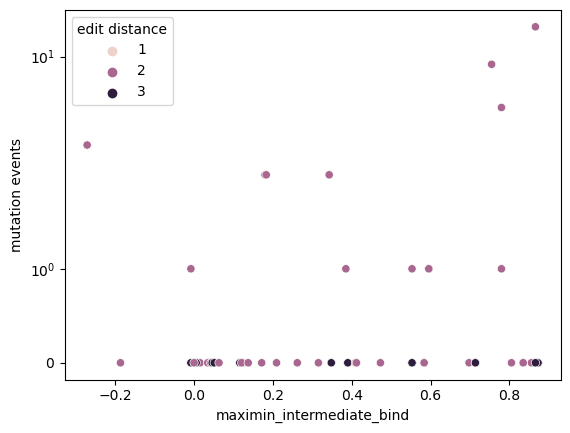

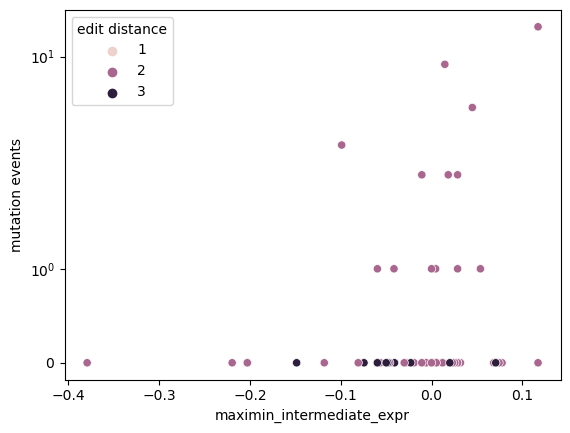

In [70]:
sns.swarmplot(data=df.query("`affinity change stratum` == 'affinity gain'"), y="first-passage time", x="edit distance", s=4)
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.yscale("symlog")
sns.swarmplot(data=df.query("`affinity change stratum` == 'affinity gain'"), y="mutation events", x="edit distance", s=4)
plt.show()

sns.scatterplot(data=df.query("`affinity change stratum` == 'affinity gain'"), y="mutation events", x="first-passage time", hue="edit distance")
# plt.xscale("log")
plt.yscale("symlog")
plt.show()

sns.scatterplot(data=df.query("`affinity change stratum` == 'affinity gain'"), y="mutation events", x="maximin_intermediate_bind", hue="edit distance")
# plt.xscale("log")
plt.yscale("symlog")
plt.show()

sns.scatterplot(data=df.query("`affinity change stratum` == 'affinity gain'"), y="mutation events", x="maximin_intermediate_expr", hue="edit distance")
# plt.xscale("log")
plt.yscale("symlog")
plt.show()

One interesting thing above is that the affinity-increasing mutations seem to have high-affinity intermediates (second-to-last) plot. Let's plot affinity of target vs intermediate:

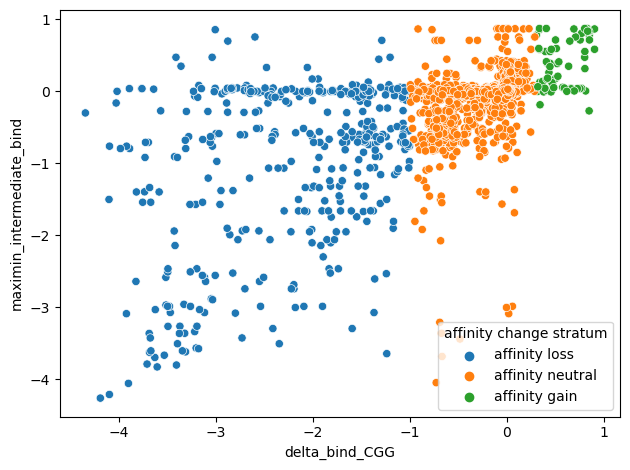

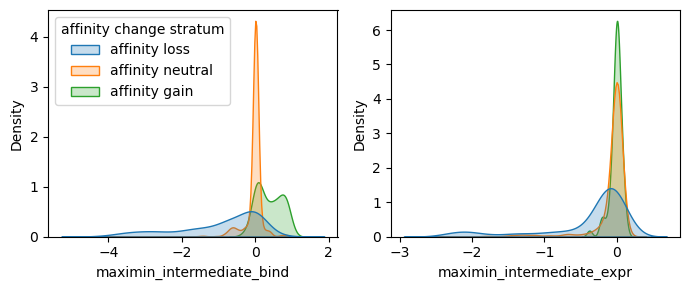

In [91]:
sns.scatterplot(data=df, x="delta_bind_CGG", y="maximin_intermediate_bind", hue="affinity change stratum",
                hue_order=["affinity loss", "affinity neutral", "affinity gain"])
plt.tight_layout()
plt.show()


plt.figure(figsize=(7, 3))

plt.subplot(121)
ax = sns.kdeplot(data=df, hue="affinity change stratum", x="maximin_intermediate_bind",
             bw_adjust=1, fill=True, common_norm=False,
             hue_order=["affinity loss", "affinity neutral", "affinity gain"])
sns.move_legend(ax, "upper left")

plt.subplot(122)
ax = sns.kdeplot(data=df, hue="affinity change stratum", x="maximin_intermediate_expr",
             bw_adjust=1, fill=True, common_norm=False, legend=False,
             hue_order=["affinity loss", "affinity neutral", "affinity gain"])

plt.tight_layout()
plt.show()

This is interesting, and I'm not sure what to make of it. Biochem question: do amino acids co-cluster by physical properties and edit distance?